# Evaluation

### 1. Most important columns

Well, considering we only have two columns in our used dataset(`is_sarcastic` and `headline`), I'd say the `headline`-column is most important since it contains all the model-input data. `is_saracastic` is only used for training and is the one we'd like to predict.<br>

(Yes, there was a column with the article link which would be a big influence, but we decided not to use that one for previously elaborated reasons)<br>

(And because of how `HashingVectorizer` works (*hashing* is one-way), it's not possible to extract original feature names)

### 2. Measuring Method

The MSE (Mean Squared Error) is mostly used for regression. It measures the difference between the predicted values and the actual values, squares it and then takes the mean of all of those. My model only has binary outputs. Either 1 (is sarcastic), or 0 (isn't sarcastic). The MSE wouldn't really capture the model's performance. <br>
In fact, the MSE would just flag any incorrect prediction with a Squared Error of 1. This for every entry. Then it takes the mean of all of those. We've just created a complex method to get the percentage of correct predictions, which isn't necessarily a bad metric, but there are much easier ways to do that.
<br><br>
So, for a more balanced evaluation I'd consider the F1-Score:
$$
F_1 = 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}
$$
The F1-Score punishes false positives and false negatives equally, which is suited for our dataset since we have a pretty even distribution of sarcastic and non-sarcastic entries. (See below)


In [1]:
import pandas as pd

headlines = pd.read_json("Sarcasm_Headlines_Dataset_v2.json")

sarcastic = 0
total = headlines['is_sarcastic'].count()

for value in headlines['is_sarcastic']:
    if value == 1:
        sarcastic += 1

print(f"Percentage of sarcastic entries: \t{str(1/total*sarcastic*100)[:5]}%")
print(f"Percentage of non-sarcastic entries: \t{str(100-(1/total*sarcastic*100))[:5]}%")

Percentage of sarcastic entries: 	47.63%
Percentage of non-sarcastic entries: 	52.36%


<br>

Now then, to calculate that score:

In [2]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import joblib  

model = joblib.load('sarcasm_model.pkl') 

X, y = headlines['headline'], headlines['is_sarcastic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # same random

y_pred = model.predict(X_test)

f1 = f1_score(y_test, y_pred, average='binary')  # For binary classification
f1_2 = f1_score(y_test, y_pred, average='macro')  # For multi-class, if applicable

print(f"F1 Score (binary): {f1}")
print(f"F1-macro Score: {f1_2}")

F1 Score (binary): 0.8454661558109834
F1-macro Score: 0.8517593892847443


And a more general evaluation just for completeness' sake:

In [3]:
from sklearn.metrics import classification_report

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      2972
           1       0.85      0.84      0.85      2752

    accuracy                           0.85      5724
   macro avg       0.85      0.85      0.85      5724
weighted avg       0.85      0.85      0.85      5724



### 3. Confusion Matrix

We've evaluated performance which seems pretty well-balanced, but now let's also create a confusion matrix to get some more insight on True Positives, False Positive, True Negatives and False Negatives. For our model False Positives and False Negatives are about equally dangerous. Interpreting something as sarcasm when it is not or thinking something is serious when sarcasm can both lead to very bad misunderstandings.

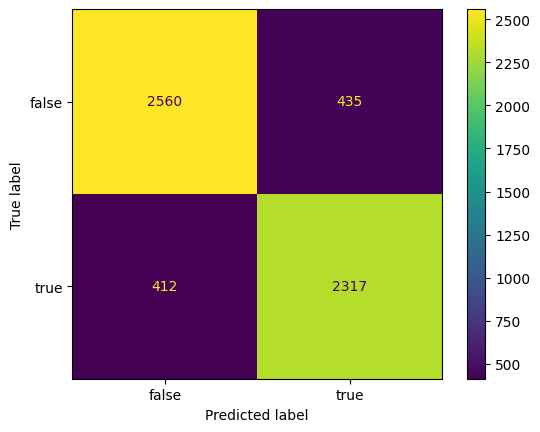

In [4]:
from sklearn.metrics import confusion_matrix

# creating the matrix
cm = confusion_matrix(y_test, y_pred)

# visualising it
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['false', 'true'], )

disp.plot()
plt.show()


Not too bad I'd say. Now for "Sensitivität" (recall) and "Spezifität" (specificity):

In [5]:
from sklearn.metrics import recall_score

# Sensitivity (Recall for positives)
sensitivity = recall_score(y_test, y_pred, pos_label=1)

# Specificity = TN / (TN + FP)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

print("Simple recall: ", sensitivity)
print("Simple specificity: ", specificity)

Simple recall:  0.8490289483327226
Simple specificity:  0.8547579298831386


### 4. Summary

I'd say my model is working quite well for something as strange and subjective as sarcasm. It's better and more consistent than me at detecting it, in the headlines at least. (You can try too, run main.py in "IGNORE_FOR_LB/5_game", I spent far too much time on this)<br>
The combination of `LinearSVC` and `HashingVectorizer` is working pretty well, `HashingVectorizer` is fast and memory efficient (which allows even me to fit it again and again), and hash collisions seem to be working in our favour here. `LinearSVC` is suited for short, structured, sparse input, which describes headlines pretty well.<br>
Another boost in model performance was the optimization with `GridSearchCV` which found a pretty good configuration. N-grams for sarcasm are pretty important too, and especially in sarcasm bigrams are pretty important. <br>
(Phrases like "yeah right", "oh great", etc.)<br><br>

Best found configuration:
```json
{'classifier__C': 1, 'classifier__class_weight': None, 'vectorizer__alternate_sign': False, 'vectorizer__ngram_range': (1, 2), 'vectorizer__norm': 'l2'}
```